# Calculate uncertainties in geodetic mass balance

## A brief introduction

The method is based on Hugonnet et al. (2022) and assess the uncertainty at 1-sigma level from the spatial correlation and the heteroscedacity of elevation change.

Hereafter, we follow two tutorials:
    - assessing the spatial correlation: https://xdem.readthedocs.io/en/latest/basic_examples/plot_infer_spatial_correlation.html
    - propagating the uncertainty: https://xdem.readthedocs.io/en/latest/basic_examples/plot_spatial_error_propagation.html
    
## Load the relevant packages

In [3]:
import geoutils as gu
import xdem
import numpy as np
import matplotlib.pyplot as plt

## Load the relevant data

In [4]:
path = 'C:/Users/brunbarf/Data/RAGMAC/WG1/validation/'

site = 'NO_Vestisen_validation_results/NO_Vestisen'

dh_map = path + site + '/' + 'NO_DoD10m_2020_2008coregist_UTM33Nellips.tif'
ref_DEM_file =  path + site + '/' + 'NO_DEM10m_20200810_UTM33Nellips.tif'
#shp_stable = path + site + '/'  + 'shp/stable_area.shp'
shp_gla = path + site + '/'  + 'shp/NO_Ves_glaciers.shp'
shp_ENG = path + site + '/'  + 'shp/RGIId01657.shp'


dh = xdem.DEM(dh_map)
ref_dem = xdem.DEM(ref_DEM_file)
glacier_outlines = gu.Vector(shp_gla)
ENG_outlines = gu.Vector(shp_ENG)



## Make sure the dh map and reference DEM are in the same proj and grid

In [5]:
# ref_dem = xdem.DEM(ref_dem).reproject(dh, silent=True)
dh = xdem.DEM(dh).reproject(ref_dem, silent=True)

## Optional: plot the dh map and DEM

(7380315.00011813, 7406295.00011813)

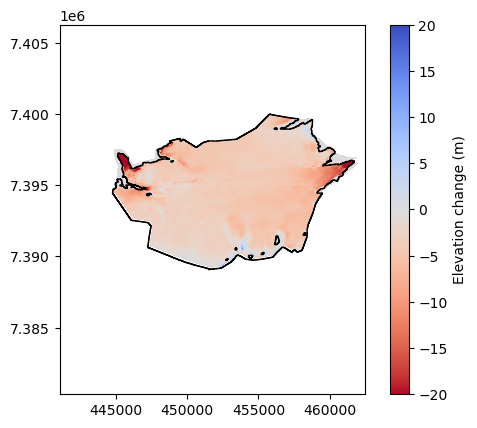

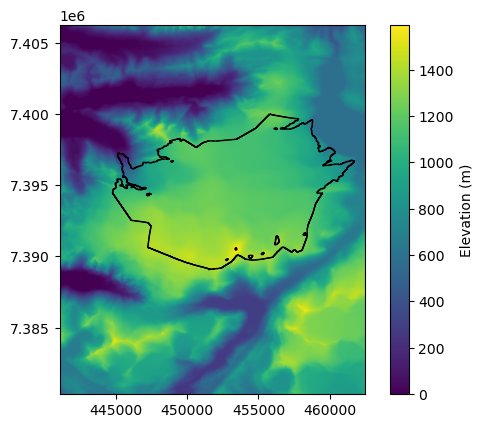

In [6]:
plt.figure()
ax = plt.subplot(111)
dh.show(ax=ax,cmap='coolwarm_r', vmin=-20, vmax=20, cb_title="Elevation change (m)")
glacier_outlines.ds.plot(ax=ax, fc="none", ec="k")
plt.xlim(dh.bounds.left, dh.bounds.right)
plt.ylim(dh.bounds.bottom, dh.bounds.top)

plt.figure()
ax = plt.subplot(111)
ref_dem.show(ax=ax,cmap='viridis', cb_title="Elevation (m)")
glacier_outlines.ds.plot(ax=ax, fc="none", ec="k")
plt.xlim(dh.bounds.left, dh.bounds.right)
plt.ylim(dh.bounds.bottom, dh.bounds.top)

## Empirical variogram and plot

In [14]:
list_models=["Spherical", "Spherical", "Spherical"]

In [15]:
(
    df_empirical_variogram,
    df_model_params,
    spatial_corr_function,
) = xdem.spatialstats.infer_spatial_correlation_from_stable(
    dvalues=dh, list_models=list_models, unstable_mask=glacier_outlines
)

C:\Users\brunbarf\Anaconda3\envs\xdem\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


## Some results from the variogram fit

In [16]:
df_model_params

,model,range,psill
0,spherical,208.181556,1.155975
0,spherical,35.051655,0.806305
0,spherical,10464.923116,0.105368


In [17]:
for spatial_lag in [0, 100, 1000, 10000, 30000]:
    print(
        "Errors are correlated at {:.1f}% for a {:,.0f} m spatial lag".format(
            spatial_corr_function(spatial_lag) * 100, spatial_lag
        )
    )

Errors are correlated at 100.0% for a 0 m spatial lag
Errors are correlated at 23.7% for a 100 m spatial lag
Errors are correlated at 4.4% for a 1,000 m spatial lag
Errors are correlated at 0.0% for a 10,000 m spatial lag
Errors are correlated at 0.0% for a 30,000 m spatial lag


## Plot the variogram

<Figure size 640x480 with 0 Axes>

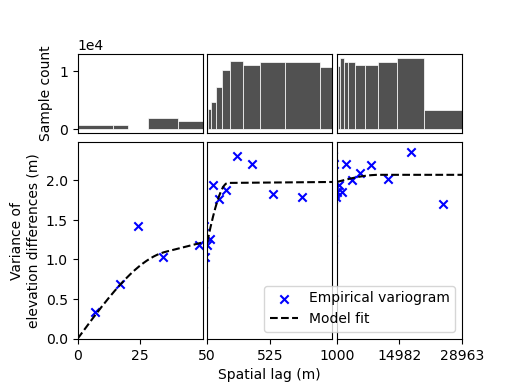

In [19]:
plt.figure()
xdem.spatialstats.plot_variogram(
    df=df_empirical_variogram,
    list_fit_fun=[xdem.spatialstats.get_variogram_model_func(df_model_params)],
    xlabel="Spatial lag (m)",
    ylabel="Variance of\nelevation differences (m)",
    xscale_range_split=[50,1000],
)

## Estimate heteroscedasticity

### First calculate terrain derivatives (slope, curvature)

In [20]:
slope, maximum_curvature = xdem.terrain.get_terrain_attribute(ref_dem, attribute=["slope", "maximum_curvature"])
errors, df_binning, error_function = xdem.spatialstats.infer_heteroscedasticity_from_stable(
    dvalues=dh, list_var=[slope, maximum_curvature], list_var_names=["slope", "maxc"], unstable_mask=glacier_outlines
)

### Normalize variance and calculate new variogram

In [21]:
zscores = dh / errors
emp_variogram, params_variogram_model, spatial_corr_function = xdem.spatialstats.infer_spatial_correlation_from_stable(
    dvalues=zscores, list_models=list_models, unstable_mask=glacier_outlines
)

C:\Users\brunbarf\Anaconda3\envs\xdem\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


### Some results from the variogram fit

In [22]:
params_variogram_model

,model,range,psill
0,spherical,32.642593,2.690038e+00
0,spherical,240.965037,1.883132e-07
0,spherical,28963.093757,4.097896e-01


### Plot normalized variogram

<Figure size 640x480 with 0 Axes>

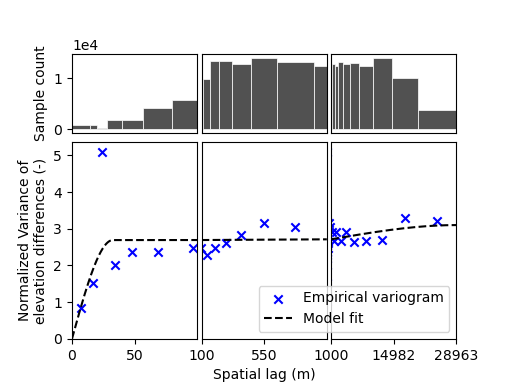

In [23]:
plt.figure()
xdem.spatialstats.plot_variogram(
    df=emp_variogram,
    list_fit_fun=[xdem.spatialstats.get_variogram_model_func(params_variogram_model)],
    xlabel="Spatial lag (m)",
    ylabel="Normalized Variance of\nelevation differences (-)",
    xscale_range_split=[100,1000],
)

## Spatial integration of variance on the target area

In [24]:
#areas = [
#    ENG_outlines.ds[ENG_outlines.ds["DN"] == 1]
#]

areas = [
    np.sqrt(36048142./np.pi), ## racine(A/pi) for ENG
    np.sqrt(41226431./np.pi), ## racine(A/pi) for STN
    np.sqrt(15911810./np.pi), ## racine(A/pi) for STS

]


areas = [
    0.1, ## racine(A/pi) for ENG
    np.sqrt(41226431./np.pi), ## racine(A/pi) for STN
    np.sqrt(15911810./np.pi), ## racine(A/pi) for STS

]

#stderr_glaciers = xdem.spatialstats.spatial_error_propagation(
#    areas=areas, params_variogram_model=params_variogram_model
#)

stderr_glaciers = xdem.spatialstats.spatial_error_propagation(
    areas=areas, errors=errors, params_variogram_model=df_model_params
)

for glacier_name, stderr_gla in [("ENG", stderr_glaciers[0]), ("STN", stderr_glaciers[1]), ("STS", stderr_glaciers[2])]:
    print(f"The error (1-sigma) in mean elevation change for {glacier_name} is {stderr_gla:.2f} meters.")

The error (1-sigma) in mean elevation change for ENG is 0.60 meters.
The error (1-sigma) in mean elevation change for STN is 0.47 meters.
The error (1-sigma) in mean elevation change for STS is 0.49 meters.


In [52]:
stderr_glaciers

[0.6008057766178257, 0.2893456287231365, 0.3400670211286008]

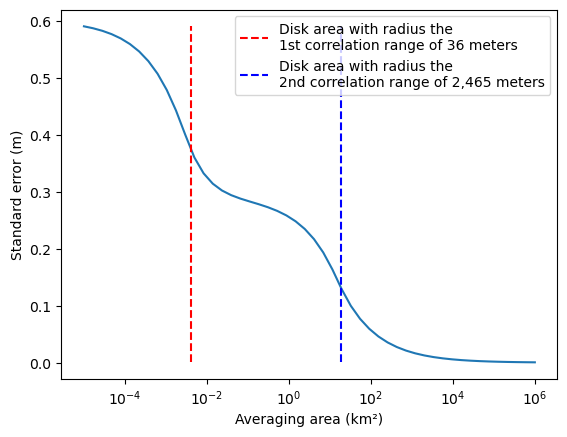

In [53]:
areas = 10 ** np.linspace(1, 12)
stderrs = xdem.spatialstats.spatial_error_propagation(
    areas=areas, errors=errors, params_variogram_model=params_variogram_model
)
plt.plot(areas / 10**6, stderrs)
plt.xlabel("Averaging area (km²)")
plt.ylabel("Standard error (m)")
plt.vlines(
    x=np.pi * params_variogram_model["range"].values[0] ** 2 / 10**6,
    ymin=np.min(stderrs),
    ymax=np.max(stderrs),
    colors="red",
    linestyles="dashed",
    label="Disk area with radius the\n1st correlation range of {:,.0f} meters".format(
        params_variogram_model["range"].values[0]
    ),
)
plt.vlines(
    x=np.pi * params_variogram_model["range"].values[1] ** 2 / 10**6,
    ymin=np.min(stderrs),
    ymax=np.max(stderrs),
    colors="blue",
    linestyles="dashed",
    label="Disk area with radius the\n2nd correlation range of {:,.0f} meters".format(
        params_variogram_model["range"].values[1]
    ),
)
plt.xscale("log")
plt.legend()
plt.show()